# 3.3 Classificador de dígitos completo

# Classificação Um-Contra-Todos (Progressivo)

Para classificar os dígitos da base, utilizamos a estratégia **Um-Contra-Todos (OvA)**, porém de forma **progressiva**.  

## Passo a Passo da Função

1. **Definição da classe positiva**  
   Em cada iteração, escolhemos um dígito específico (por exemplo, **0**) e o rotulamos como **𝑦 = +1**.  
   Todos os demais são tratados como **𝑦 = −1**.

2. **Treinamento do primeiro classificador**  
   O primeiro modelo é treinado no formato **[dígito alvo] vs [todos os outros]**.  
   Exemplo: para o dígito **0**, temos **0 vs (1, 4, 5, …)**.

3. **Filtragem progressiva**  
   Antes de treinar o próximo classificador, a classe já utilizada é **removida** do conjunto de treino.  
   Assim:
   - Para o dígito **1**, o treino será **1 vs (4, 5, …)**, já que os exemplos da classe **0** foram excluídos.  
   - Para o dígito **4**, o treino será **4 vs (5, …)**, pois as classes **0** e **1** já foram removidas.

4. **Escalonamento**  
   Cada subconjunto é normalizado com `StandardScaler` antes do treino, garantindo que as features tenham mesma escala.

5. **Treinamento independente**  
   Um classificador é treinado para cada dígito da lista alvo. O resultado é um dicionário com os modelos e seus respectivos escalonadores.

---

### Importação das bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron, LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import warnings
import itertools

In [2]:
warnings.filterwarnings("ignore")

### Funções

In [3]:
def um_contra_todos(classificador, X_train, y_train, digitos_alvo=[0, 1, 4]):
    classificadores_dict = {}

    for idx, digito in enumerate(digitos_alvo):
        y_bin = np.where(y_train == digito, 1, -1)
        
        if idx > 0:
            mask = y_train != digitos_alvo[idx - 1]
            X_train_filtrado = X_train[mask]
            y_bin = y_bin[mask]
        else:
            X_train_filtrado = X_train

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_filtrado)

        clf = classificador()
        clf.fit(X_train_scaled, y_bin)

        classificadores_dict[digito] = (clf, scaler)

    return classificadores_dict

In [4]:
def previsoes(classificador, X_test, y_test, classificadores):
    preds = []
    for x in X_test:
        pred = None
        
        if classificador == LinearRegression:
            for digito, (clf, scaler) in classificadores.items():
                x_scaled = scaler.transform([x])
                y_cont = clf.predict(x_scaled)[0]
                if y_cont >= 0:
                    pred = digito
                    break
        else:
            for digito, (clf, scaler) in classificadores.items():
                x_scaled = scaler.transform([x])
                if clf.predict(x_scaled)[0] == 1:
                    pred = digito
                    break
        if pred is None:
            pred = 5
        preds.append(pred)

    print(f"\nModelo: {classificador.__name__}")
    print(classification_report(y_test, preds, digits=2))
    
    return classificadores, preds

In [5]:
def plot_fronteira_e_matriz(classificadores, X, y, modelo_tipo="Modelo", digitos_alvo=[0,1,4], fallback=5):
    cores_pontos = {0:'orange', 1:'blue', 4:'green', 5:'red'}
    cores_linhas = {0:'red', 1:'blue', 4:'green'}

    plt.figure(figsize=(14,6))

    # Subplot 1: Fronteiras
    ax1 = plt.subplot(1,2,1)
    
    # Plotar pontos
    for digito in np.unique(y):
        mask = y == digito
        ax1.scatter(X[mask,0], X[mask,1], c=cores_pontos.get(digito, 'black'),
                    alpha=0.6, s=20, label=f'Dígito {digito}')

    # Criar grid para fronteiras
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Plotar fronteiras
    for digito, (modelo, scaler) in classificadores.items():
        grid_scaled = scaler.transform(grid_points)
        y_cont = modelo.predict(grid_scaled).reshape(xx.shape)
        ax1.contour(xx, yy, y_cont, levels=[0], colors=cores_linhas.get(digito, 'black'),
                    linestyles='--', linewidths=2)

    ax1.set_xlabel("Intensidade")
    ax1.set_ylabel("Simetria")
    ax1.set_title(f"Fronteiras de Decisão - {modelo_tipo}")
    ax1.legend()
    ax1.grid(True, linestyle="--", alpha=0.3)


    # Subplot 2: Matriz de Confusão
    ax2 = plt.subplot(1,2,2)
    
    preds = []
    for x_sample in X:
        pred = fallback
        for digito, (clf, scaler) in classificadores.items():
            x_scaled = scaler.transform([x_sample])
            if modelo_tipo == "LinearRegression":
                y_cont = clf.predict(x_scaled)[0]
                if y_cont >= 0:
                    pred = digito
                    break
            else:
                if clf.predict(x_scaled)[0] == 1:
                    pred = digito
                    break
        preds.append(pred)
    
    cm = confusion_matrix(y, preds, labels=digitos_alvo + [fallback])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=digitos_alvo + [fallback])
    disp.plot(ax=ax2, cmap=plt.cm.Blues)
    ax2.set_title("Matriz de Confusão")

    plt.tight_layout()
    plt.show()

### Separação os dados

In [6]:
train = pd.read_csv('dataset/train_redu.csv')
test = pd.read_csv('dataset/test_redu.csv')

In [7]:
X_train = train.drop(columns=['label']).values
y_train = train['label'].values

X_test = test.drop(columns=['label']).values
y_test = test['label'].values

### Perceptron


Modelo: Perceptron
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       218
           1       1.00      1.00      1.00       292
           4       0.87      1.00      0.93       314
           5       1.00      0.83      0.90       291

    accuracy                           0.95      1115
   macro avg       0.96      0.96      0.96      1115
weighted avg       0.96      0.95      0.95      1115



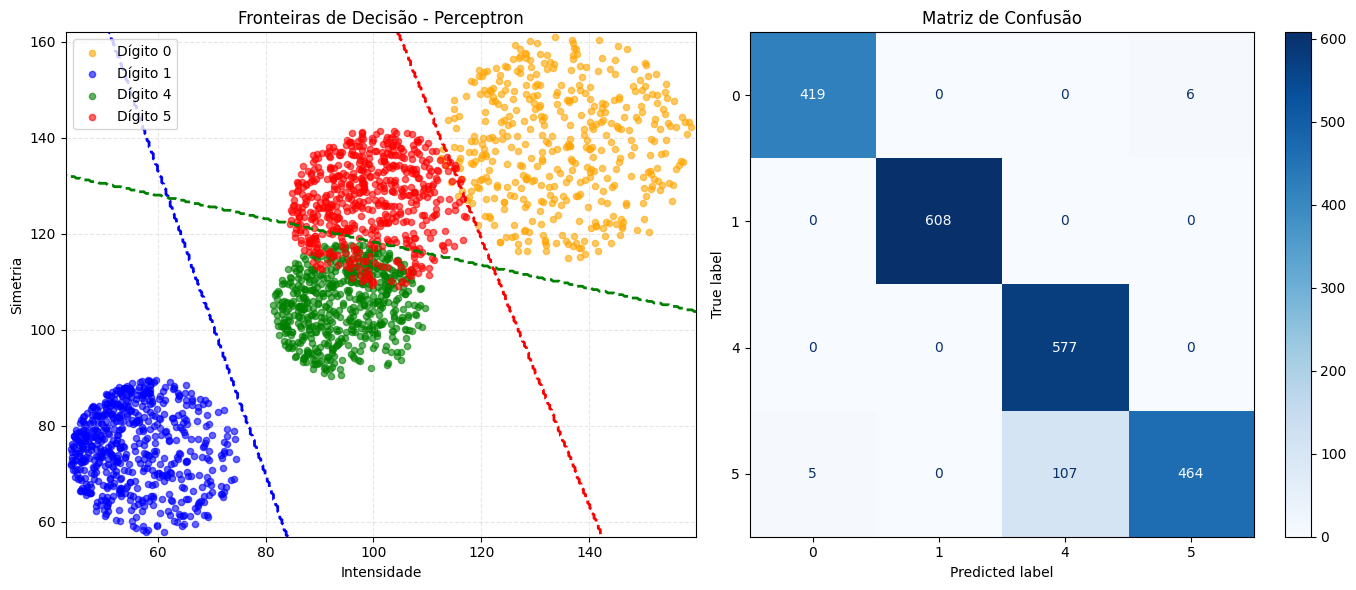

In [8]:
classificadores = um_contra_todos(Perceptron, X_train, y_train)
classificadores, preds = previsoes(Perceptron, X_test, y_test, classificadores)
plot_fronteira_e_matriz(classificadores, X_train, y_train, modelo_tipo="Perceptron")
# plot_fronteira_e_matriz(classificadores, X_test, y_test, modelo_tipo="Perceptron")

### Regressão Linear


Modelo: LinearRegression
              precision    recall  f1-score   support

           0       1.00      0.80      0.89       218
           1       1.00      1.00      1.00       292
           4       0.92      0.98      0.95       314
           5       0.84      0.91      0.87       291

    accuracy                           0.93      1115
   macro avg       0.94      0.92      0.93      1115
weighted avg       0.94      0.93      0.93      1115



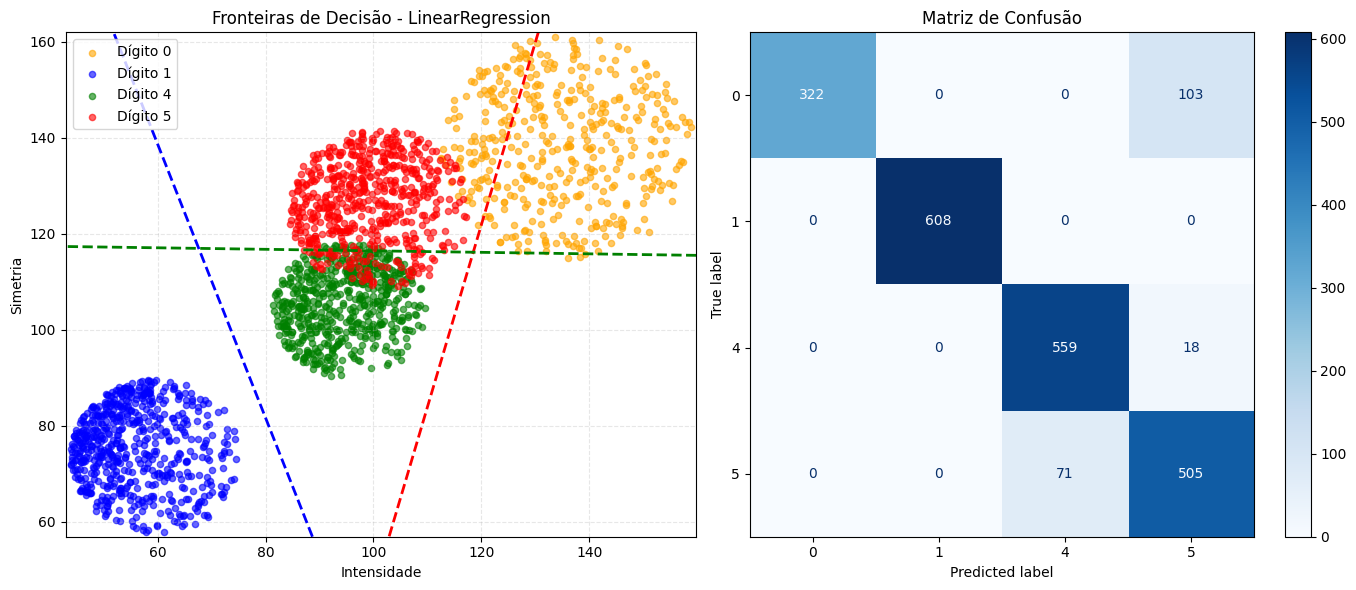

In [9]:
classificadores = um_contra_todos(LinearRegression, X_train, y_train)
classificadores, preds = previsoes(LinearRegression, X_test, y_test, classificadores)
plot_fronteira_e_matriz(classificadores, X_train, y_train, modelo_tipo="LinearRegression")
# plot_fronteira_e_matriz(classificadores, X_test, y_test, modelo_tipo="LinearRegression") 

### Regressão Logística


Modelo: LogisticRegression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       218
           1       1.00      1.00      1.00       292
           4       0.94      0.95      0.94       314
           5       0.94      0.93      0.94       291

    accuracy                           0.97      1115
   macro avg       0.97      0.97      0.97      1115
weighted avg       0.97      0.97      0.97      1115



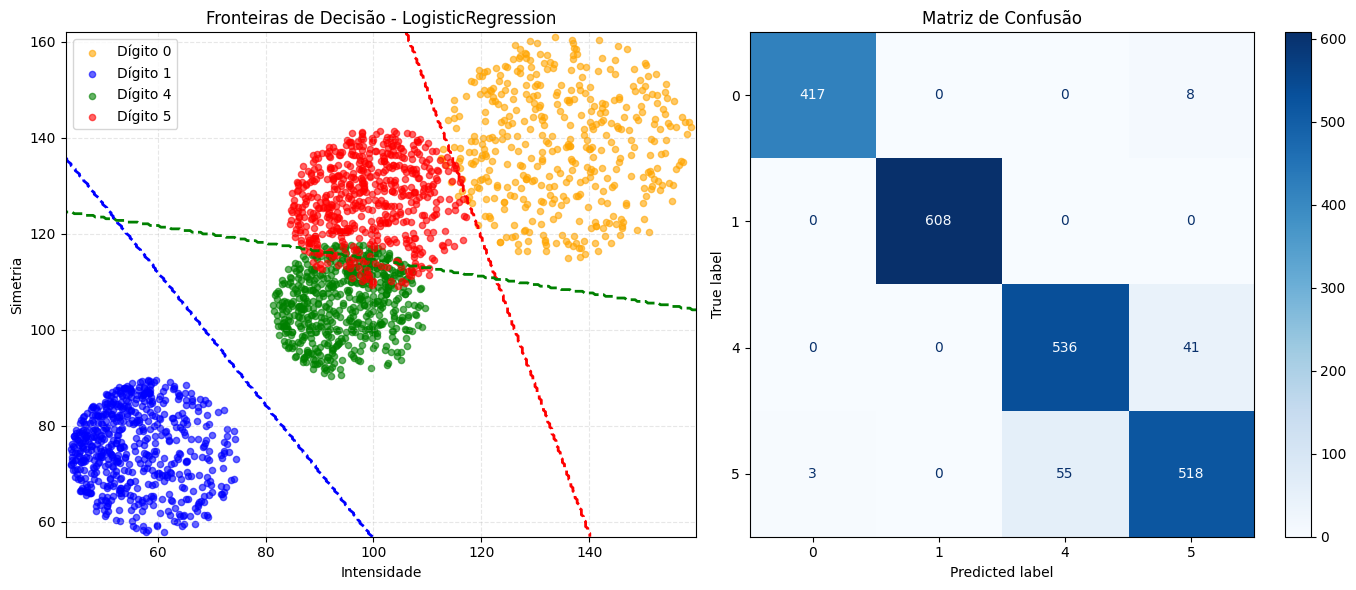

In [10]:
# Para LogisticRegression
classificadores = um_contra_todos(LogisticRegression, X_train, y_train)
classificadores, preds = previsoes(LogisticRegression, X_test, y_test, classificadores)
plot_fronteira_e_matriz(classificadores, X_train, y_train, modelo_tipo="LogisticRegression")
# plot_fronteira_e_matriz(classificadores, X_test, y_test, modelo_tipo="LogisticRegression")

# 4. Implementações avançadas

### 4.1 Predição com weight decay

In [11]:
def logistic_ova(X_train, y_train, digitos_alvo=[0,1,4,5], lambda_val=0.1):
    C_val = 1 / lambda_val
    classificadores = {}

    for idx, digito in enumerate(digitos_alvo):
        y_bin = np.where(y_train == digito, 1, -1)

        if idx > 0:
            mask = y_train != digitos_alvo[idx-1]
            X_train_filtrado = X_train[mask]
            y_bin = y_bin[mask]
        else:
            X_train_filtrado = X_train

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_filtrado)

        clf = LogisticRegression(penalty='l2', C=C_val, solver='lbfgs', max_iter=1000, class_weight='balanced')
        clf.fit(X_train_scaled, y_bin)

        classificadores[digito] = (clf, scaler)

    return classificadores


In [12]:
def previsoes_logistic(X_test, y_test, classificadores, fallback=5):
    preds = []

    for x in X_test:
        pred = None
        for digito, (clf, scaler) in classificadores.items():
            x_scaled = scaler.transform([x])
            if clf.predict(x_scaled)[0] == 1:
                pred = digito
                break
        if pred is None:
            pred = fallback
        preds.append(pred)

    print("\nModelo: LogisticRegression")
    print(classification_report(y_test, preds, digits=2))

    return classificadores, preds


Modelo: LogisticRegression
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       218
           1       1.00      1.00      1.00       292
           4       0.92      0.98      0.95       314
           5       0.97      0.86      0.91       291

    accuracy                           0.96      1115
   macro avg       0.96      0.96      0.96      1115
weighted avg       0.96      0.96      0.96      1115



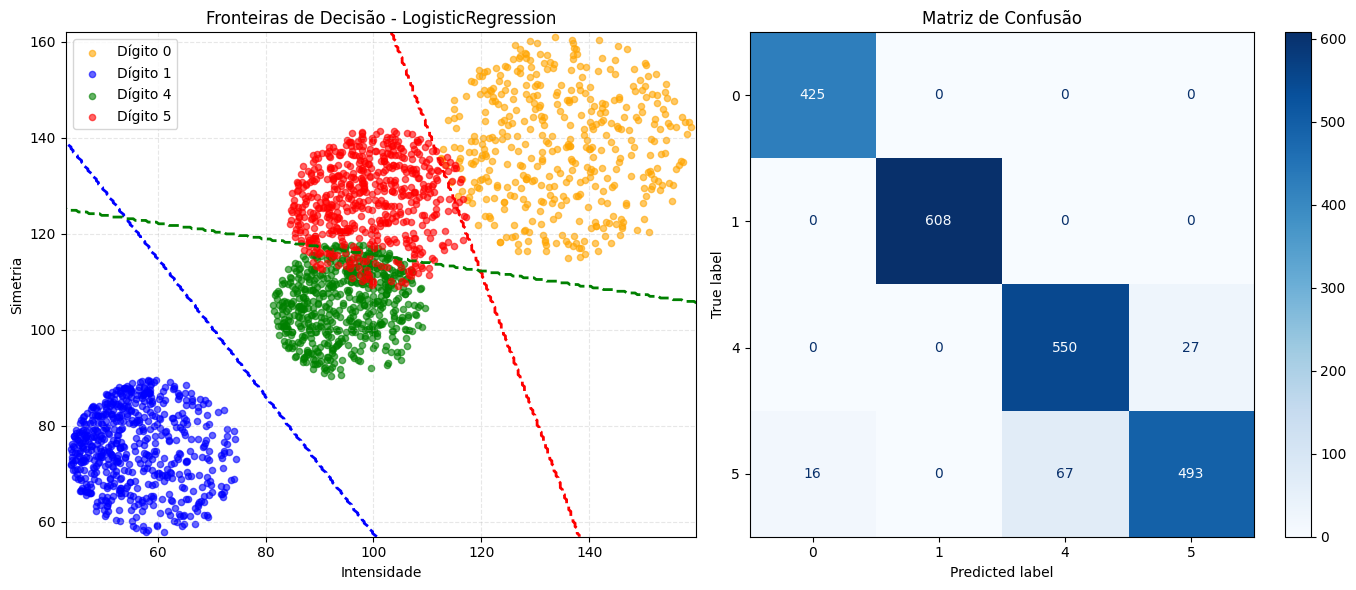

In [13]:
classificadores = logistic_ova(X_train, y_train, digitos_alvo=[0,1,4], lambda_val=0.1)
classificadores, preds = previsoes_logistic(X_test, y_test, classificadores, fallback=5)

plot_fronteira_e_matriz(classificadores, X_train, y_train, modelo_tipo="LogisticRegression", digitos_alvo=[0,1,4], fallback=5)


### 4.2 Melhor ordem de teste

In [14]:
def otimizar_ordem_um_contra_todos(modelo_clf, X_train, y_train, X_test, y_test, digitos_alvo=[0,1,4,5]):
    melhor_ordem = None
    melhor_acuracia = 0
    melhor_classificadores = None
    melhor_preds = None

    # Faz as permutações possíveis
    for ordem in itertools.permutations(digitos_alvo):
        classificadores = {}
        for idx, digito in enumerate(ordem):
            y_bin = np.where(y_train == digito, 1, -1)
            if idx > 0:
                mask = y_train != ordem[idx - 1]
                X_train_filtrado = X_train[mask]
                y_bin = y_bin[mask]
            else:
                X_train_filtrado = X_train

            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_filtrado)

            clf = modelo_clf()
            clf.fit(X_train_scaled, y_bin)

            classificadores[digito] = (clf, scaler)

        # Faz previsões usando a ordem atual
        preds = []
        for x in X_test:
            pred = None
            for digito in ordem:
                clf, scaler = classificadores[digito]
                x_scaled = scaler.transform([x])
                y_pred = clf.predict(x_scaled)[0]
                if (modelo_clf == LinearRegression and y_pred >= 0) or (y_pred == 1):
                    pred = digito
                    break
            if pred is None:
                pred = 5
            preds.append(pred)

        # Calcula acurácia da ordem atual
        acc = accuracy_score(y_test, preds)

        # Verifica se a acurácia atual é melhor que a melhor acurácia encontrada até agora
        if acc > melhor_acuracia:
            melhor_acuracia = acc
            melhor_ordem = ordem
            melhor_classificadores = classificadores
            melhor_preds = preds

    print(f"Melhor ordem: {melhor_ordem}, Acurácia: {melhor_acuracia:.4f}")
    return melhor_classificadores, melhor_preds, melhor_ordem


In [15]:
classificadores, preds, ordem = otimizar_ordem_um_contra_todos(Perceptron, X_train, y_train, X_test, y_test)

Melhor ordem: (0, 1, 4, 5), Acurácia: 0.9543


In [16]:
classificadores, preds, ordem = otimizar_ordem_um_contra_todos(LinearRegression, X_train, y_train, X_test, y_test)

Melhor ordem: (1, 4, 0, 5), Acurácia: 0.9363


In [17]:
classificadores, preds, ordem = otimizar_ordem_um_contra_todos(LogisticRegression, X_train, y_train, X_test, y_test)

Melhor ordem: (0, 1, 4, 5), Acurácia: 0.9668
